# COVID-19 Detection Using Multi-Phase Training of ConvNets with Multi-Class Imbalanced Chest CT Scan Data

The main sections of the notebook are:

1. [Import Needed Libraries](#a)
2. [Logistic Regression](#b)
3. [Training with smotesampled Data](#c)
4. [Two-Phase Training with Undersampling](#d)
5. [Multi-Phase Training with Undersampling](#e)

<div style="text-align: right"> Ahmet Talha Yiğit / 507191101 </div>

<a id=’a’></a>
### 1. Import Needed Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support,classification_report
from sklearn.metrics import average_precision_score,PrecisionRecallDisplay, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import PredefinedSplit,GridSearchCV
from sklearn.model_selection import train_test_split



In [2]:
def lift_scorer(target, pred_proba):
    
    df = pd.DataFrame(pred_proba)
    df.columns = ['pred_proba']
    df['target'] = target.values
    df['pred_proba_rank'] = df['pred_proba'].rank(ascending = False).astype(int)
    lift = round(df[df['pred_proba_rank'] <= round(df['pred_proba_rank'].max() * (1/100), 0)]['target'].sum() / df['target'].sum() * 100, 1)

    return lift

In [3]:
X_train = pd.read_pickle('./Data/X_train_preprocessed.pkl')
y_train = pd.read_pickle('./Data/y_train_preprocessed.pkl')
X_val = pd.read_pickle('./Data/X_val_preprocessed.pkl')
y_val = pd.read_pickle('./Data/y_val_preprocessed.pkl')
X_test = pd.read_pickle('./Data/X_test_preprocessed.pkl')
y_test = pd.read_pickle('./Data/y_test_preprocessed.pkl')

In [4]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((60000, 33), (60000,), (7500, 33), (7500,), (7500, 33), (7500,))

In [5]:
X_train = X_train.reset_index()
y_train = y_train.reset_index()
X_val = X_val.reset_index()
y_val = y_val.reset_index()
X_test = X_test.reset_index()
y_test = y_test.reset_index()

X_train['idx'] = 'Train'
y_train['idx'] = 'Train'
X_val['idx'] = 'Val'
y_val['idx'] = 'Val'
X_test['idx'] = 'Test'
y_test['idx'] = 'Test'

X_train['index'] = X_train['index'].astype('str')
y_train['index'] = y_train['index'].astype('str')
X_val['index'] = X_val['index'].astype('str')
y_val['index'] = y_val['index'].astype('str')
X_test['index'] = X_test['index'].astype('str')
y_test['index'] = y_test['index'].astype('str')

X_train['index'] = X_train[["index", "idx"]].apply("-".join, axis=1)
y_train['index'] = y_train[["index", "idx"]].apply("-".join, axis=1)
X_val['index'] = X_val[["index", "idx"]].apply("-".join, axis=1)
y_val['index'] = y_val[["index", "idx"]].apply("-".join, axis=1)
X_test['index'] = X_test[["index", "idx"]].apply("-".join, axis=1)
y_test['index'] = y_test[["index", "idx"]].apply("-".join, axis=1)

X_train = X_train.set_index('index')
y_train = y_train.set_index('index')
X_val = X_val.set_index('index')
y_val = y_val.set_index('index')
X_test = X_test.set_index('index')
y_test = y_test.set_index('index')

X_train = X_train.drop('idx', axis = 1)
y_train = y_train.drop('idx', axis = 1)
X_val = X_val.drop('idx', axis = 1)
y_val = y_val.drop('idx', axis = 1)
X_test = X_test.drop('idx', axis = 1)
y_test = y_test.drop('idx', axis = 1)

In [6]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((60000, 33), (60000, 1), (7500, 33), (7500, 1), (7500, 33), (7500, 1))

In [7]:
X_train.head()

,Var_1,Var_2,Var_3,Var_4,Var_5,Var_6,Var_7,Var_8,Var_9,Var_10,...,Var_27,Var_28,Var_30,Var_31,Var_33,Var_34,Var_36,Var_38,Var_39,Var_41
index,,,,,,,,,,,,,,,,,,,,,
60075-Train,-0.109742,1.134404,-1.009085,-3.644704,-1.627865,-0.470549,0.480831,0.641715,0.194911,0.634267,...,-0.144079,-0.247141,-0.249080,0.240094,-0.396241,-1.289230,-0.039831,-0.345385,-0.233373,-0.006544
27225-Train,-0.109742,0.075986,0.977945,-0.731477,-1.627865,-0.470549,0.480831,0.641715,0.194911,0.634267,...,-0.144079,-0.247141,-0.249080,0.240094,0.533820,0.640053,-0.039831,-0.345385,-0.233373,-0.006544
403-Train,-0.109742,0.075986,0.702450,-0.631123,0.562187,-0.470549,0.480831,0.641715,0.194911,0.634267,...,0.063240,-0.247141,4.014773,0.240094,2.491077,0.640053,-0.039831,-0.345385,-0.233373,-0.006544
27953-Train,-0.109742,-0.408430,0.702450,1.045385,0.613346,-0.470549,0.480831,0.641715,0.194911,0.634267,...,0.063240,-0.247141,-0.249080,0.240094,0.169018,0.640053,-0.039831,-0.345385,-0.233373,-0.006544
74481-Train,-0.109742,-0.408430,0.702450,0.077261,1.008509,1.183906,0.480831,0.641715,0.194911,-1.576622,...,-0.144079,0.475470,-0.249080,0.240094,0.455636,0.640053,-0.039831,-0.345385,-0.233373,-0.006544


<a id=’b’></a>
## 2. Ensemble Trials

In [58]:
IF_y_train_predict_resampled_tuned = pd.read_pickle('./IF predictions/y_train_predict.pkl')
IF_y_val_predict_resampled_tuned = pd.read_pickle('./IF predictions/y_val_predict.pkl')
IF_y_test_predict_resampled_tuned = pd.read_pickle('./IF predictions/y_test_predict.pkl')
IF_y_train_predict_proba_resampled_tuned = pd.read_pickle('./IF predictions/y_train_predict_proba.pkl')[1]
IF_y_val_predict_proba_resampled_tuned = pd.read_pickle('./IF predictions/y_val_predict_proba.pkl')[1]
IF_y_test_predict_proba_resampled_tuned = pd.read_pickle('./IF predictions/y_test_predict_proba.pkl')[1]

In [59]:
LGBM_y_train_predict_resampled_tuned = pd.read_pickle('./LGBM predictions/y_train_predict.pkl')
LGBM_y_val_predict_resampled_tuned = pd.read_pickle('./LGBM predictions/y_val_predict.pkl')
LGBM_y_test_predict_resampled_tuned = pd.read_pickle('./LGBM predictions/y_test_predict.pkl')
LGBM_y_train_predict_proba_resampled_tuned = pd.read_pickle('./LGBM predictions/y_train_predict_proba.pkl')[1]
LGBM_y_val_predict_proba_resampled_tuned = pd.read_pickle('./LGBM predictions/y_val_predict_proba.pkl')[1]
LGBM_y_test_predict_proba_resampled_tuned = pd.read_pickle('./LGBM predictions/y_test_predict_proba.pkl')[1]

In [60]:
DQN_y_train_predict_resampled_tuned = pd.read_pickle('./RL predictions/y_train_predict.pkl')
DQN_y_val_predict_resampled_tuned = pd.read_pickle('./RL predictions/y_val_predict.pkl')
DQN_y_test_predict_resampled_tuned = pd.read_pickle('./RL predictions/y_test_predict.pkl')
DQN_y_train_predict_proba_resampled_tuned = pd.read_pickle('./RL predictions/y_train_predict_proba.pkl')
DQN_y_val_predict_proba_resampled_tuned = pd.read_pickle('./RL predictions/y_val_predict_proba.pkl')
DQN_y_test_predict_proba_resampled_tuned = pd.read_pickle('./RL predictions/y_test_predict_proba.pkl')

In [61]:
df_train_pred = pd.DataFrame(IF_y_train_predict_resampled_tuned)
df_train_pred['IF'] = IF_y_train_predict_resampled_tuned
df_train_pred['LGBM'] = LGBM_y_train_predict_resampled_tuned
df_train_pred['DQN'] = DQN_y_train_predict_resampled_tuned
df_train_pred.drop(0, inplace= True, axis =1)

df_val_pred = pd.DataFrame(IF_y_val_predict_resampled_tuned)
df_val_pred['IF'] = IF_y_val_predict_resampled_tuned
df_val_pred['LGBM'] = LGBM_y_val_predict_resampled_tuned
df_val_pred['DQN'] = DQN_y_val_predict_resampled_tuned
df_val_pred.drop(0, inplace= True, axis =1)

df_test_pred = pd.DataFrame(IF_y_test_predict_resampled_tuned)
df_test_pred['IF'] = IF_y_test_predict_resampled_tuned
df_test_pred['LGBM'] = LGBM_y_test_predict_resampled_tuned
df_test_pred['DQN'] = DQN_y_test_predict_resampled_tuned
df_test_pred.drop(0, inplace= True, axis =1)

In [62]:
df_train_pred_proba = pd.DataFrame(IF_y_train_predict_proba_resampled_tuned)
df_train_pred_proba['IF'] = IF_y_train_predict_proba_resampled_tuned
df_train_pred_proba['LGBM'] = LGBM_y_train_predict_proba_resampled_tuned
df_train_pred_proba['DQN'] = DQN_y_train_predict_proba_resampled_tuned
df_train_pred_proba.drop(1, inplace= True, axis =1)

df_val_pred_proba = pd.DataFrame(IF_y_val_predict_proba_resampled_tuned)
df_val_pred_proba['IF'] = IF_y_val_predict_proba_resampled_tuned
df_val_pred_proba['LGBM'] = LGBM_y_val_predict_proba_resampled_tuned
df_val_pred_proba['DQN'] = DQN_y_val_predict_proba_resampled_tuned
df_val_pred_proba.drop(1, inplace= True, axis =1)

df_test_pred_proba = pd.DataFrame(IF_y_test_predict_proba_resampled_tuned)
df_test_pred_proba['IF'] = IF_y_test_predict_proba_resampled_tuned
df_test_pred_proba['LGBM'] = LGBM_y_test_predict_proba_resampled_tuned
df_test_pred_proba['DQN'] = DQN_y_test_predict_proba_resampled_tuned
df_test_pred_proba.drop(1, inplace= True, axis =1)

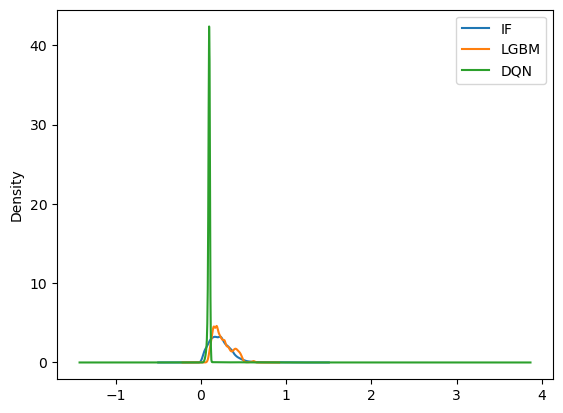

In [67]:
df_train_pred_proba.plot.kde()
plt.show()

In [79]:
df_train_pred_proba['Ensemble1'] = (df_train_pred_proba['IF'] + df_train_pred_proba['LGBM'] + df_train_pred_proba['DQN']) /3
df_val_pred_proba['Ensemble1'] = (df_val_pred_proba['IF'] + df_val_pred_proba['LGBM'] + df_val_pred_proba['DQN']) /3
df_test_pred_proba['Ensemble1'] = (df_test_pred_proba['IF'] + df_test_pred_proba['LGBM'] + df_test_pred_proba['DQN']) /3
df_train_pred.loc[df_train_pred_proba['Ensemble1'] >= 0.5, 'Ensemble1'] = 1
df_train_pred.loc[df_train_pred_proba['Ensemble1'] < 0.5, 'Ensemble1'] = 0
df_val_pred.loc[df_val_pred_proba['Ensemble1'] >= 0.5, 'Ensemble1'] = 1
df_val_pred.loc[df_val_pred_proba['Ensemble1'] < 0.5, 'Ensemble1'] = 0
df_test_pred.loc[df_test_pred_proba['Ensemble1'] >= 0.5, 'Ensemble1'] = 1
df_test_pred.loc[df_test_pred_proba['Ensemble1'] < 0.5, 'Ensemble1'] = 0

In [80]:
df_train_pred_proba['Ensemble2'] = (2*df_train_pred_proba['IF'] + 6*df_train_pred_proba['LGBM'] + 2*df_train_pred_proba['DQN']) /10
df_val_pred_proba['Ensemble2'] = (2*df_val_pred_proba['IF'] + 6*df_val_pred_proba['LGBM'] + 2*df_val_pred_proba['DQN']) /10
df_test_pred_proba['Ensemble2'] = (2*df_test_pred_proba['IF'] + 6*df_test_pred_proba['LGBM'] + 2*df_test_pred_proba['DQN']) /10
df_train_pred.loc[df_train_pred_proba['Ensemble2'] >= 0.5, 'Ensemble2'] = 1
df_train_pred.loc[df_train_pred_proba['Ensemble2'] < 0.5, 'Ensemble2'] = 0
df_val_pred.loc[df_val_pred_proba['Ensemble2'] >= 0.5, 'Ensemble2'] = 1
df_val_pred.loc[df_val_pred_proba['Ensemble2'] < 0.5, 'Ensemble2'] = 0
df_test_pred.loc[df_test_pred_proba['Ensemble2'] >= 0.5, 'Ensemble2'] = 1
df_test_pred.loc[df_test_pred_proba['Ensemble2'] < 0.5, 'Ensemble2'] = 0

In [81]:
df_train_pred_proba['Ensemble3'] = (df_train_pred_proba['IF'] + 8*df_train_pred_proba['LGBM'] + df_train_pred_proba['DQN']) /10
df_val_pred_proba['Ensemble3'] = (df_val_pred_proba['IF'] + 8*df_val_pred_proba['LGBM'] + df_val_pred_proba['DQN']) /10
df_test_pred_proba['Ensemble3'] = (df_test_pred_proba['IF'] + 8*df_test_pred_proba['LGBM'] + df_test_pred_proba['DQN']) /10
df_train_pred.loc[df_train_pred_proba['Ensemble3'] >= 0.5, 'Ensemble3'] = 1
df_train_pred.loc[df_train_pred_proba['Ensemble3'] < 0.5, 'Ensemble3'] = 0
df_val_pred.loc[df_val_pred_proba['Ensemble3'] >= 0.5, 'Ensemble3'] = 1
df_val_pred.loc[df_val_pred_proba['Ensemble3'] < 0.5, 'Ensemble3'] = 0
df_test_pred.loc[df_test_pred_proba['Ensemble3'] >= 0.5, 'Ensemble3'] = 1
df_test_pred.loc[df_test_pred_proba['Ensemble3'] < 0.5, 'Ensemble3'] = 0

In [86]:
print('Training Data:')
accuracy = accuracy_score(y_train,df_train_pred['IF'])
precision = precision_score(y_train,df_train_pred['IF'])
recall = recall_score(y_train,df_train_pred['IF'])
f1 = f1_score(y_train,df_train_pred['IF'])
roc_auc = roc_auc_score(y_train,df_train_pred_proba['IF'])
lift_score = lift_scorer(y_train, df_train_pred_proba['IF'])
print('IF', '\t\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_train,df_train_pred['LGBM'])
precision = precision_score(y_train,df_train_pred['LGBM'])
recall = recall_score(y_train,df_train_pred['LGBM'])
f1 = f1_score(y_train,df_train_pred['LGBM'])
roc_auc = roc_auc_score(y_train,df_train_pred_proba['LGBM'])
lift_score = lift_scorer(y_train, df_train_pred_proba['LGBM'])
print('LGBM', '\t\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_train,df_train_pred['DQN'])
precision = precision_score(y_train,df_train_pred['DQN'])
recall = recall_score(y_train,df_train_pred['DQN'])
f1 = f1_score(y_train,df_train_pred['DQN'])
roc_auc = roc_auc_score(y_train,df_train_pred_proba['DQN'])
lift_score = lift_scorer(y_train, df_train_pred_proba['DQN'])
print('DQN', '\t\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_train,df_train_pred['Ensemble1'])
precision = precision_score(y_train,df_train_pred['Ensemble1'])
recall = recall_score(y_train,df_train_pred['Ensemble1'])
f1 = f1_score(y_train,df_train_pred['Ensemble1'])
roc_auc = roc_auc_score(y_train,df_train_pred_proba['Ensemble1'])
lift_score = lift_scorer(y_train, df_train_pred_proba['Ensemble1'])
print('Ensemble1', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_train,df_train_pred['Ensemble2'])
precision = precision_score(y_train,df_train_pred['Ensemble2'])
recall = recall_score(y_train,df_train_pred['Ensemble2'])
f1 = f1_score(y_train,df_train_pred['Ensemble2'])
roc_auc = roc_auc_score(y_train,df_train_pred_proba['Ensemble2'])
lift_score = lift_scorer(y_train, df_train_pred_proba['Ensemble2'])
print('Ensemble2', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_train,df_train_pred['Ensemble3'])
precision = precision_score(y_train,df_train_pred['Ensemble3'])
recall = recall_score(y_train,df_train_pred['Ensemble3'])
f1 = f1_score(y_train,df_train_pred['Ensemble3'])
roc_auc = roc_auc_score(y_train,df_train_pred_proba['Ensemble3'])
lift_score = lift_scorer(y_train, df_train_pred_proba['Ensemble3'])
print('Ensemble3', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
print('--------------------------------------------------------------------------------------------------------------------------------------------')
print('Validation Data:')
accuracy = accuracy_score(y_val,df_val_pred['IF'])
precision = precision_score(y_val,df_val_pred['IF'])
recall = recall_score(y_val,df_val_pred['IF'])
f1 = f1_score(y_val,df_val_pred['IF'])
roc_auc = roc_auc_score(y_val,df_val_pred_proba['IF'])
lift_score = lift_scorer(y_val, df_val_pred_proba['IF'])
print('IF', '\t\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_val,df_val_pred['LGBM'])
precision = precision_score(y_val,df_val_pred['LGBM'])
recall = recall_score(y_val,df_val_pred['LGBM'])
f1 = f1_score(y_val,df_val_pred['LGBM'])
roc_auc = roc_auc_score(y_val,df_val_pred_proba['LGBM'])
lift_score = lift_scorer(y_val, df_val_pred_proba['LGBM'])
print('LGBM', '\t\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\t\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_val,df_val_pred['DQN'])
precision = precision_score(y_val,df_val_pred['DQN'])
recall = recall_score(y_val,df_val_pred['DQN'])
f1 = f1_score(y_val,df_val_pred['DQN'])
roc_auc = roc_auc_score(y_val,df_val_pred_proba['DQN'])
lift_score = lift_scorer(y_val, df_val_pred_proba['DQN'])
print('DQN', '\t\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_val,df_val_pred['Ensemble1'])
precision = precision_score(y_val,df_val_pred['Ensemble1'])
recall = recall_score(y_val,df_val_pred['Ensemble1'])
f1 = f1_score(y_val,df_val_pred['Ensemble1'])
roc_auc = roc_auc_score(y_val,df_val_pred_proba['Ensemble1'])
lift_score = lift_scorer(y_val, df_val_pred_proba['Ensemble1'])
print('Ensemble1', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_val,df_val_pred['Ensemble2'])
precision = precision_score(y_val,df_val_pred['Ensemble2'])
recall = recall_score(y_val,df_val_pred['Ensemble2'])
f1 = f1_score(y_val,df_val_pred['Ensemble2'])
roc_auc = roc_auc_score(y_val,df_val_pred_proba['Ensemble2'])
lift_score = lift_scorer(y_val, df_val_pred_proba['Ensemble2'])
print('Ensemble2', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\t\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_val,df_val_pred['Ensemble3'])
precision = precision_score(y_val,df_val_pred['Ensemble3'])
recall = recall_score(y_val,df_val_pred['Ensemble3'])
f1 = f1_score(y_val,df_val_pred['Ensemble3'])
roc_auc = roc_auc_score(y_val,df_val_pred_proba['Ensemble3'])
lift_score = lift_scorer(y_val, df_val_pred_proba['Ensemble3'])
print('Ensemble3', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
print('--------------------------------------------------------------------------------------------------------------------------------------------')
print('Test Data:')
accuracy = accuracy_score(y_test,df_test_pred['IF'])
precision = precision_score(y_test,df_test_pred['IF'])
recall = recall_score(y_test,df_test_pred['IF'])
f1 = f1_score(y_test,df_test_pred['IF'])
roc_auc = roc_auc_score(y_test,df_test_pred_proba['IF'])
lift_score = lift_scorer(y_test, df_test_pred_proba['IF'])
print('IF', '\t\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_test,df_test_pred['LGBM'])
precision = precision_score(y_test,df_test_pred['LGBM'])
recall = recall_score(y_test,df_test_pred['LGBM'])
f1 = f1_score(y_test,df_test_pred['LGBM'])
roc_auc = roc_auc_score(y_test,df_test_pred_proba['LGBM'])
lift_score = lift_scorer(y_test, df_test_pred_proba['LGBM'])
print('LGBM', '\t\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_test,df_test_pred['DQN'])
precision = precision_score(y_test,df_test_pred['DQN'])
recall = recall_score(y_test,df_test_pred['DQN'])
f1 = f1_score(y_test,df_test_pred['DQN'])
roc_auc = roc_auc_score(y_test,df_test_pred_proba['DQN'])
lift_score = lift_scorer(y_test, df_test_pred_proba['DQN'])
print('DQN', '\t\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_test,df_test_pred['Ensemble1'])
precision = precision_score(y_test,df_test_pred['Ensemble1'])
recall = recall_score(y_test,df_test_pred['Ensemble1'])
f1 = f1_score(y_test,df_test_pred['Ensemble1'])
roc_auc = roc_auc_score(y_test,df_test_pred_proba['Ensemble1'])
lift_score = lift_scorer(y_test, df_test_pred_proba['Ensemble1'])
print('Ensemble1', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_test,df_test_pred['Ensemble2'])
precision = precision_score(y_test,df_test_pred['Ensemble2'])
recall = recall_score(y_test,df_test_pred['Ensemble2'])
f1 = f1_score(y_test,df_test_pred['Ensemble2'])
roc_auc = roc_auc_score(y_test,df_test_pred_proba['Ensemble2'])
lift_score = lift_scorer(y_test, df_test_pred_proba['Ensemble2'])
print('Ensemble2', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_test,df_test_pred['Ensemble3'])
precision = precision_score(y_test,df_test_pred['Ensemble3'])
recall = recall_score(y_test,df_test_pred['Ensemble3'])
f1 = f1_score(y_test,df_test_pred['Ensemble3'])
roc_auc = roc_auc_score(y_test,df_test_pred_proba['Ensemble3'])
lift_score = lift_scorer(y_test, df_test_pred_proba['Ensemble3'])
print('Ensemble3', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))

Training Data:
IF 		accuracy: 0.9827 	precision: 0.135 	recall: 0.135 	f1: 0.135 	roc_auc: 0.6688 	lift: 13.5
LGBM 		accuracy: 0.9826 	precision: 0.1764 	recall: 0.2017 	f1: 0.1882 	roc_auc: 0.8458 	lift: 18.7
DQN 		accuracy: 0.974 	precision: 0.1242 	recall: 0.265 	f1: 0.1691 	roc_auc: 0.3953 	lift: 17.2
Ensemble1 	accuracy: 0.9844 	precision: 0.1844 	recall: 0.165 	f1: 0.1741 	roc_auc: 0.7864 	lift: 17.3
Ensemble2 	accuracy: 0.9841 	precision: 0.1836 	recall: 0.1717 	f1: 0.1774 	roc_auc: 0.8308 	lift: 17.3
Ensemble3 	accuracy: 0.9838 	precision: 0.179 	recall: 0.1733 	f1: 0.1761 	roc_auc: 0.8422 	lift: 17.7
--------------------------------------------------------------------------------------------------------------------------------------------
Validation Data:
IF 		accuracy: 0.984 	precision: 0.1429 	recall: 0.12 	f1: 0.1304 	roc_auc: 0.6647 	lift: 12.0
LGBM 		accuracy: 0.9837 	precision: 0.2025 	recall: 0.2133 	f1: 0.2078 	roc_auc: 0.827 		lift: 18.7
DQN 		accuracy: 0.9737 	precis

In [87]:
df_train_pred_proba['Ensemble1'] = (5*df_train_pred_proba['IF'] + 5*df_train_pred_proba['LGBM'] ) /10
df_val_pred_proba['Ensemble1'] = (5*df_val_pred_proba['IF'] + 5*df_val_pred_proba['LGBM'] ) /10
df_test_pred_proba['Ensemble1'] = (5*df_test_pred_proba['IF'] + 5*df_test_pred_proba['LGBM'] ) /10
df_train_pred.loc[df_train_pred_proba['Ensemble1'] >= 0.5, 'Ensemble1'] = 1
df_train_pred.loc[df_train_pred_proba['Ensemble1'] < 0.5, 'Ensemble1'] = 0
df_val_pred.loc[df_val_pred_proba['Ensemble1'] >= 0.5, 'Ensemble1'] = 1
df_val_pred.loc[df_val_pred_proba['Ensemble1'] < 0.5, 'Ensemble1'] = 0
df_test_pred.loc[df_test_pred_proba['Ensemble1'] >= 0.5, 'Ensemble1'] = 1
df_test_pred.loc[df_test_pred_proba['Ensemble1'] < 0.5, 'Ensemble1'] = 0

In [88]:
df_train_pred_proba['Ensemble2'] = (2*df_train_pred_proba['IF'] + 8*df_train_pred_proba['LGBM'] ) /10
df_val_pred_proba['Ensemble2'] = (2*df_val_pred_proba['IF'] + 8*df_val_pred_proba['LGBM'] ) /10
df_test_pred_proba['Ensemble2'] = (2*df_test_pred_proba['IF'] + 8*df_test_pred_proba['LGBM'] ) /10
df_train_pred.loc[df_train_pred_proba['Ensemble2'] >= 0.5, 'Ensemble2'] = 1
df_train_pred.loc[df_train_pred_proba['Ensemble2'] < 0.5, 'Ensemble2'] = 0
df_val_pred.loc[df_val_pred_proba['Ensemble2'] >= 0.5, 'Ensemble2'] = 1
df_val_pred.loc[df_val_pred_proba['Ensemble2'] < 0.5, 'Ensemble2'] = 0
df_test_pred.loc[df_test_pred_proba['Ensemble2'] >= 0.5, 'Ensemble2'] = 1
df_test_pred.loc[df_test_pred_proba['Ensemble2'] < 0.5, 'Ensemble2'] = 0

In [89]:
df_train_pred_proba['Ensemble3'] = (1*df_train_pred_proba['IF'] + 9*df_train_pred_proba['LGBM'] ) /10
df_val_pred_proba['Ensemble3'] = (1*df_val_pred_proba['IF'] + 9*df_val_pred_proba['LGBM'] ) /10
df_test_pred_proba['Ensemble3'] = (1*df_test_pred_proba['IF'] + 9*df_test_pred_proba['LGBM'] ) /10
df_train_pred.loc[df_train_pred_proba['Ensemble3'] >= 0.5, 'Ensemble3'] = 1
df_train_pred.loc[df_train_pred_proba['Ensemble3'] < 0.5, 'Ensemble3'] = 0
df_val_pred.loc[df_val_pred_proba['Ensemble3'] >= 0.5, 'Ensemble3'] = 1
df_val_pred.loc[df_val_pred_proba['Ensemble3'] < 0.5, 'Ensemble3'] = 0
df_test_pred.loc[df_test_pred_proba['Ensemble3'] >= 0.5, 'Ensemble3'] = 1
df_test_pred.loc[df_test_pred_proba['Ensemble3'] < 0.5, 'Ensemble3'] = 0

In [91]:
print('Training Data:')
accuracy = accuracy_score(y_train,df_train_pred['IF'])
precision = precision_score(y_train,df_train_pred['IF'])
recall = recall_score(y_train,df_train_pred['IF'])
f1 = f1_score(y_train,df_train_pred['IF'])
roc_auc = roc_auc_score(y_train,df_train_pred_proba['IF'])
lift_score = lift_scorer(y_train, df_train_pred_proba['IF'])
print('IF', '\t\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_train,df_train_pred['LGBM'])
precision = precision_score(y_train,df_train_pred['LGBM'])
recall = recall_score(y_train,df_train_pred['LGBM'])
f1 = f1_score(y_train,df_train_pred['LGBM'])
roc_auc = roc_auc_score(y_train,df_train_pred_proba['LGBM'])
lift_score = lift_scorer(y_train, df_train_pred_proba['LGBM'])
print('LGBM', '\t\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_train,df_train_pred['DQN'])
precision = precision_score(y_train,df_train_pred['DQN'])
recall = recall_score(y_train,df_train_pred['DQN'])
f1 = f1_score(y_train,df_train_pred['DQN'])
roc_auc = roc_auc_score(y_train,df_train_pred_proba['DQN'])
lift_score = lift_scorer(y_train, df_train_pred_proba['DQN'])
print('DQN', '\t\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_train,df_train_pred['Ensemble1'])
precision = precision_score(y_train,df_train_pred['Ensemble1'])
recall = recall_score(y_train,df_train_pred['Ensemble1'])
f1 = f1_score(y_train,df_train_pred['Ensemble1'])
roc_auc = roc_auc_score(y_train,df_train_pred_proba['Ensemble1'])
lift_score = lift_scorer(y_train, df_train_pred_proba['Ensemble1'])
print('Ensemble1', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_train,df_train_pred['Ensemble2'])
precision = precision_score(y_train,df_train_pred['Ensemble2'])
recall = recall_score(y_train,df_train_pred['Ensemble2'])
f1 = f1_score(y_train,df_train_pred['Ensemble2'])
roc_auc = roc_auc_score(y_train,df_train_pred_proba['Ensemble2'])
lift_score = lift_scorer(y_train, df_train_pred_proba['Ensemble2'])
print('Ensemble2', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_train,df_train_pred['Ensemble3'])
precision = precision_score(y_train,df_train_pred['Ensemble3'])
recall = recall_score(y_train,df_train_pred['Ensemble3'])
f1 = f1_score(y_train,df_train_pred['Ensemble3'])
roc_auc = roc_auc_score(y_train,df_train_pred_proba['Ensemble3'])
lift_score = lift_scorer(y_train, df_train_pred_proba['Ensemble3'])
print('Ensemble3', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
print('--------------------------------------------------------------------------------------------------------------------------------------------')
print('Validation Data:')
accuracy = accuracy_score(y_val,df_val_pred['IF'])
precision = precision_score(y_val,df_val_pred['IF'])
recall = recall_score(y_val,df_val_pred['IF'])
f1 = f1_score(y_val,df_val_pred['IF'])
roc_auc = roc_auc_score(y_val,df_val_pred_proba['IF'])
lift_score = lift_scorer(y_val, df_val_pred_proba['IF'])
print('IF', '\t\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_val,df_val_pred['LGBM'])
precision = precision_score(y_val,df_val_pred['LGBM'])
recall = recall_score(y_val,df_val_pred['LGBM'])
f1 = f1_score(y_val,df_val_pred['LGBM'])
roc_auc = roc_auc_score(y_val,df_val_pred_proba['LGBM'])
lift_score = lift_scorer(y_val, df_val_pred_proba['LGBM'])
print('LGBM', '\t\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\t\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_val,df_val_pred['DQN'])
precision = precision_score(y_val,df_val_pred['DQN'])
recall = recall_score(y_val,df_val_pred['DQN'])
f1 = f1_score(y_val,df_val_pred['DQN'])
roc_auc = roc_auc_score(y_val,df_val_pred_proba['DQN'])
lift_score = lift_scorer(y_val, df_val_pred_proba['DQN'])
print('DQN', '\t\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_val,df_val_pred['Ensemble1'])
precision = precision_score(y_val,df_val_pred['Ensemble1'])
recall = recall_score(y_val,df_val_pred['Ensemble1'])
f1 = f1_score(y_val,df_val_pred['Ensemble1'])
roc_auc = roc_auc_score(y_val,df_val_pred_proba['Ensemble1'])
lift_score = lift_scorer(y_val, df_val_pred_proba['Ensemble1'])
print('Ensemble1', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_val,df_val_pred['Ensemble2'])
precision = precision_score(y_val,df_val_pred['Ensemble2'])
recall = recall_score(y_val,df_val_pred['Ensemble2'])
f1 = f1_score(y_val,df_val_pred['Ensemble2'])
roc_auc = roc_auc_score(y_val,df_val_pred_proba['Ensemble2'])
lift_score = lift_scorer(y_val, df_val_pred_proba['Ensemble2'])
print('Ensemble2', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_val,df_val_pred['Ensemble3'])
precision = precision_score(y_val,df_val_pred['Ensemble3'])
recall = recall_score(y_val,df_val_pred['Ensemble3'])
f1 = f1_score(y_val,df_val_pred['Ensemble3'])
roc_auc = roc_auc_score(y_val,df_val_pred_proba['Ensemble3'])
lift_score = lift_scorer(y_val, df_val_pred_proba['Ensemble3'])
print('Ensemble3', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
print('--------------------------------------------------------------------------------------------------------------------------------------------')
print('Test Data:')
accuracy = accuracy_score(y_test,df_test_pred['IF'])
precision = precision_score(y_test,df_test_pred['IF'])
recall = recall_score(y_test,df_test_pred['IF'])
f1 = f1_score(y_test,df_test_pred['IF'])
roc_auc = roc_auc_score(y_test,df_test_pred_proba['IF'])
lift_score = lift_scorer(y_test, df_test_pred_proba['IF'])
print('IF', '\t\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_test,df_test_pred['LGBM'])
precision = precision_score(y_test,df_test_pred['LGBM'])
recall = recall_score(y_test,df_test_pred['LGBM'])
f1 = f1_score(y_test,df_test_pred['LGBM'])
roc_auc = roc_auc_score(y_test,df_test_pred_proba['LGBM'])
lift_score = lift_scorer(y_test, df_test_pred_proba['LGBM'])
print('LGBM', '\t\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_test,df_test_pred['DQN'])
precision = precision_score(y_test,df_test_pred['DQN'])
recall = recall_score(y_test,df_test_pred['DQN'])
f1 = f1_score(y_test,df_test_pred['DQN'])
roc_auc = roc_auc_score(y_test,df_test_pred_proba['DQN'])
lift_score = lift_scorer(y_test, df_test_pred_proba['DQN'])
print('DQN', '\t\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_test,df_test_pred['Ensemble1'])
precision = precision_score(y_test,df_test_pred['Ensemble1'])
recall = recall_score(y_test,df_test_pred['Ensemble1'])
f1 = f1_score(y_test,df_test_pred['Ensemble1'])
roc_auc = roc_auc_score(y_test,df_test_pred_proba['Ensemble1'])
lift_score = lift_scorer(y_test, df_test_pred_proba['Ensemble1'])
print('Ensemble1', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_test,df_test_pred['Ensemble2'])
precision = precision_score(y_test,df_test_pred['Ensemble2'])
recall = recall_score(y_test,df_test_pred['Ensemble2'])
f1 = f1_score(y_test,df_test_pred['Ensemble2'])
roc_auc = roc_auc_score(y_test,df_test_pred_proba['Ensemble2'])
lift_score = lift_scorer(y_test, df_test_pred_proba['Ensemble2'])
print('Ensemble2', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_test,df_test_pred['Ensemble3'])
precision = precision_score(y_test,df_test_pred['Ensemble3'])
recall = recall_score(y_test,df_test_pred['Ensemble3'])
f1 = f1_score(y_test,df_test_pred['Ensemble3'])
roc_auc = roc_auc_score(y_test,df_test_pred_proba['Ensemble3'])
lift_score = lift_scorer(y_test, df_test_pred_proba['Ensemble3'])
print('Ensemble3', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))

Training Data:
IF 		accuracy: 0.9827 	precision: 0.135 	recall: 0.135 	f1: 0.135 	roc_auc: 0.6688 	lift: 13.5
LGBM 		accuracy: 0.9826 	precision: 0.1764 	recall: 0.2017 	f1: 0.1882 	roc_auc: 0.8458 	lift: 18.7
DQN 		accuracy: 0.974 	precision: 0.1242 	recall: 0.265 	f1: 0.1691 	roc_auc: 0.3953 	lift: 17.2
Ensemble1 	accuracy: 0.9824 	precision: 0.1599 	recall: 0.1783 	f1: 0.1686 	roc_auc: 0.793 	lift: 17.3
Ensemble2 	accuracy: 0.9834 	precision: 0.1772 	recall: 0.1817 	f1: 0.1794 	roc_auc: 0.8372 	lift: 18.0
Ensemble3 	accuracy: 0.9833 	precision: 0.1812 	recall: 0.19 	f1: 0.1855 	roc_auc: 0.8432 	lift: 18.3
--------------------------------------------------------------------------------------------------------------------------------------------
Validation Data:
IF 		accuracy: 0.984 	precision: 0.1429 	recall: 0.12 	f1: 0.1304 	roc_auc: 0.6647 	lift: 12.0
LGBM 		accuracy: 0.9837 	precision: 0.2025 	recall: 0.2133 	f1: 0.2078 	roc_auc: 0.827 		lift: 18.7
DQN 		accuracy: 0.9737 	precisi

In [ ]:
df_train_pred_proba['Ensemble1'] = (5*df_train_pred_proba['DQN'] + 5*df_train_pred_proba['LGBM'] ) /10
df_val_pred_proba['Ensemble1'] = (5*df_val_pred_proba['DQN'] + 5*df_val_pred_proba['LGBM'] ) /10
df_test_pred_proba['Ensemble1'] = (5*df_test_pred_proba['DQN'] + 5*df_test_pred_proba['LGBM'] ) /10
df_train_pred.loc[df_train_pred_proba['Ensemble1'] >= 0.5, 'Ensemble1'] = 1
df_train_pred.loc[df_train_pred_proba['Ensemble1'] < 0.5, 'Ensemble1'] = 0
df_val_pred.loc[df_val_pred_proba['Ensemble1'] >= 0.5, 'Ensemble1'] = 1
df_val_pred.loc[df_val_pred_proba['Ensemble1'] < 0.5, 'Ensemble1'] = 0
df_test_pred.loc[df_test_pred_proba['Ensemble1'] >= 0.5, 'Ensemble1'] = 1
df_test_pred.loc[df_test_pred_proba['Ensemble1'] < 0.5, 'Ensemble1'] = 0

In [ ]:
df_train_pred_proba['Ensemble2'] = (2*df_train_pred_proba['DQN'] + 8*df_train_pred_proba['LGBM'] ) /10
df_val_pred_proba['Ensemble2'] = (2*df_val_pred_proba['DQN'] + 8*df_val_pred_proba['LGBM'] ) /10
df_test_pred_proba['Ensemble2'] = (2*df_test_pred_proba['DQN'] + 8*df_test_pred_proba['LGBM'] ) /10
df_train_pred.loc[df_train_pred_proba['Ensemble2'] >= 0.5, 'Ensemble2'] = 1
df_train_pred.loc[df_train_pred_proba['Ensemble2'] < 0.5, 'Ensemble2'] = 0
df_val_pred.loc[df_val_pred_proba['Ensemble2'] >= 0.5, 'Ensemble2'] = 1
df_val_pred.loc[df_val_pred_proba['Ensemble2'] < 0.5, 'Ensemble2'] = 0
df_test_pred.loc[df_test_pred_proba['Ensemble2'] >= 0.5, 'Ensemble2'] = 1
df_test_pred.loc[df_test_pred_proba['Ensemble2'] < 0.5, 'Ensemble2'] = 0

In [ ]:
df_train_pred_proba['Ensemble3'] = (1*df_train_pred_proba['DQN'] + 9*df_train_pred_proba['LGBM'] ) /10
df_val_pred_proba['Ensemble3'] = (1*df_val_pred_proba['DQN'] + 9*df_val_pred_proba['LGBM'] ) /10
df_test_pred_proba['Ensemble3'] = (1*df_test_pred_proba['DQN'] + 9*df_test_pred_proba['LGBM'] ) /10
df_train_pred.loc[df_train_pred_proba['Ensemble3'] >= 0.5, 'Ensemble3'] = 1
df_train_pred.loc[df_train_pred_proba['Ensemble3'] < 0.5, 'Ensemble3'] = 0
df_val_pred.loc[df_val_pred_proba['Ensemble3'] >= 0.5, 'Ensemble3'] = 1
df_val_pred.loc[df_val_pred_proba['Ensemble3'] < 0.5, 'Ensemble3'] = 0
df_test_pred.loc[df_test_pred_proba['Ensemble3'] >= 0.5, 'Ensemble3'] = 1
df_test_pred.loc[df_test_pred_proba['Ensemble3'] < 0.5, 'Ensemble3'] = 0

In [93]:
print('Training Data:')
accuracy = accuracy_score(y_train,df_train_pred['IF'])
precision = precision_score(y_train,df_train_pred['IF'])
recall = recall_score(y_train,df_train_pred['IF'])
f1 = f1_score(y_train,df_train_pred['IF'])
roc_auc = roc_auc_score(y_train,df_train_pred_proba['IF'])
lift_score = lift_scorer(y_train, df_train_pred_proba['IF'])
print('IF', '\t\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_train,df_train_pred['LGBM'])
precision = precision_score(y_train,df_train_pred['LGBM'])
recall = recall_score(y_train,df_train_pred['LGBM'])
f1 = f1_score(y_train,df_train_pred['LGBM'])
roc_auc = roc_auc_score(y_train,df_train_pred_proba['LGBM'])
lift_score = lift_scorer(y_train, df_train_pred_proba['LGBM'])
print('LGBM', '\t\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_train,df_train_pred['DQN'])
precision = precision_score(y_train,df_train_pred['DQN'])
recall = recall_score(y_train,df_train_pred['DQN'])
f1 = f1_score(y_train,df_train_pred['DQN'])
roc_auc = roc_auc_score(y_train,df_train_pred_proba['DQN'])
lift_score = lift_scorer(y_train, df_train_pred_proba['DQN'])
print('DQN', '\t\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_train,df_train_pred['Ensemble1'])
precision = precision_score(y_train,df_train_pred['Ensemble1'])
recall = recall_score(y_train,df_train_pred['Ensemble1'])
f1 = f1_score(y_train,df_train_pred['Ensemble1'])
roc_auc = roc_auc_score(y_train,df_train_pred_proba['Ensemble1'])
lift_score = lift_scorer(y_train, df_train_pred_proba['Ensemble1'])
print('Ensemble1', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\t\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_train,df_train_pred['Ensemble2'])
precision = precision_score(y_train,df_train_pred['Ensemble2'])
recall = recall_score(y_train,df_train_pred['Ensemble2'])
f1 = f1_score(y_train,df_train_pred['Ensemble2'])
roc_auc = roc_auc_score(y_train,df_train_pred_proba['Ensemble2'])
lift_score = lift_scorer(y_train, df_train_pred_proba['Ensemble2'])
print('Ensemble2', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_train,df_train_pred['Ensemble3'])
precision = precision_score(y_train,df_train_pred['Ensemble3'])
recall = recall_score(y_train,df_train_pred['Ensemble3'])
f1 = f1_score(y_train,df_train_pred['Ensemble3'])
roc_auc = roc_auc_score(y_train,df_train_pred_proba['Ensemble3'])
lift_score = lift_scorer(y_train, df_train_pred_proba['Ensemble3'])
print('Ensemble3', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
print('--------------------------------------------------------------------------------------------------------------------------------------------')
print('Validation Data:')
accuracy = accuracy_score(y_val,df_val_pred['IF'])
precision = precision_score(y_val,df_val_pred['IF'])
recall = recall_score(y_val,df_val_pred['IF'])
f1 = f1_score(y_val,df_val_pred['IF'])
roc_auc = roc_auc_score(y_val,df_val_pred_proba['IF'])
lift_score = lift_scorer(y_val, df_val_pred_proba['IF'])
print('IF', '\t\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_val,df_val_pred['LGBM'])
precision = precision_score(y_val,df_val_pred['LGBM'])
recall = recall_score(y_val,df_val_pred['LGBM'])
f1 = f1_score(y_val,df_val_pred['LGBM'])
roc_auc = roc_auc_score(y_val,df_val_pred_proba['LGBM'])
lift_score = lift_scorer(y_val, df_val_pred_proba['LGBM'])
print('LGBM', '\t\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\t\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_val,df_val_pred['DQN'])
precision = precision_score(y_val,df_val_pred['DQN'])
recall = recall_score(y_val,df_val_pred['DQN'])
f1 = f1_score(y_val,df_val_pred['DQN'])
roc_auc = roc_auc_score(y_val,df_val_pred_proba['DQN'])
lift_score = lift_scorer(y_val, df_val_pred_proba['DQN'])
print('DQN', '\t\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_val,df_val_pred['Ensemble1'])
precision = precision_score(y_val,df_val_pred['Ensemble1'])
recall = recall_score(y_val,df_val_pred['Ensemble1'])
f1 = f1_score(y_val,df_val_pred['Ensemble1'])
roc_auc = roc_auc_score(y_val,df_val_pred_proba['Ensemble1'])
lift_score = lift_scorer(y_val, df_val_pred_proba['Ensemble1'])
print('Ensemble1', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_val,df_val_pred['Ensemble2'])
precision = precision_score(y_val,df_val_pred['Ensemble2'])
recall = recall_score(y_val,df_val_pred['Ensemble2'])
f1 = f1_score(y_val,df_val_pred['Ensemble2'])
roc_auc = roc_auc_score(y_val,df_val_pred_proba['Ensemble2'])
lift_score = lift_scorer(y_val, df_val_pred_proba['Ensemble2'])
print('Ensemble2', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_val,df_val_pred['Ensemble3'])
precision = precision_score(y_val,df_val_pred['Ensemble3'])
recall = recall_score(y_val,df_val_pred['Ensemble3'])
f1 = f1_score(y_val,df_val_pred['Ensemble3'])
roc_auc = roc_auc_score(y_val,df_val_pred_proba['Ensemble3'])
lift_score = lift_scorer(y_val, df_val_pred_proba['Ensemble3'])
print('Ensemble3', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
print('--------------------------------------------------------------------------------------------------------------------------------------------')
print('Test Data:')
accuracy = accuracy_score(y_test,df_test_pred['IF'])
precision = precision_score(y_test,df_test_pred['IF'])
recall = recall_score(y_test,df_test_pred['IF'])
f1 = f1_score(y_test,df_test_pred['IF'])
roc_auc = roc_auc_score(y_test,df_test_pred_proba['IF'])
lift_score = lift_scorer(y_test, df_test_pred_proba['IF'])
print('IF', '\t\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_test,df_test_pred['LGBM'])
precision = precision_score(y_test,df_test_pred['LGBM'])
recall = recall_score(y_test,df_test_pred['LGBM'])
f1 = f1_score(y_test,df_test_pred['LGBM'])
roc_auc = roc_auc_score(y_test,df_test_pred_proba['LGBM'])
lift_score = lift_scorer(y_test, df_test_pred_proba['LGBM'])
print('LGBM', '\t\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_test,df_test_pred['DQN'])
precision = precision_score(y_test,df_test_pred['DQN'])
recall = recall_score(y_test,df_test_pred['DQN'])
f1 = f1_score(y_test,df_test_pred['DQN'])
roc_auc = roc_auc_score(y_test,df_test_pred_proba['DQN'])
lift_score = lift_scorer(y_test, df_test_pred_proba['DQN'])
print('DQN', '\t\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_test,df_test_pred['Ensemble1'])
precision = precision_score(y_test,df_test_pred['Ensemble1'])
recall = recall_score(y_test,df_test_pred['Ensemble1'])
f1 = f1_score(y_test,df_test_pred['Ensemble1'])
roc_auc = roc_auc_score(y_test,df_test_pred_proba['Ensemble1'])
lift_score = lift_scorer(y_test, df_test_pred_proba['Ensemble1'])
print('Ensemble1', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_test,df_test_pred['Ensemble2'])
precision = precision_score(y_test,df_test_pred['Ensemble2'])
recall = recall_score(y_test,df_test_pred['Ensemble2'])
f1 = f1_score(y_test,df_test_pred['Ensemble2'])
roc_auc = roc_auc_score(y_test,df_test_pred_proba['Ensemble2'])
lift_score = lift_scorer(y_test, df_test_pred_proba['Ensemble2'])
print('Ensemble2', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_test,df_test_pred['Ensemble3'])
precision = precision_score(y_test,df_test_pred['Ensemble3'])
recall = recall_score(y_test,df_test_pred['Ensemble3'])
f1 = f1_score(y_test,df_test_pred['Ensemble3'])
roc_auc = roc_auc_score(y_test,df_test_pred_proba['Ensemble3'])
lift_score = lift_scorer(y_test, df_test_pred_proba['Ensemble3'])
print('Ensemble3', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))

Training Data:
IF 		accuracy: 0.9827 	precision: 0.135 	recall: 0.135 	f1: 0.135 	roc_auc: 0.6688 	lift: 13.5
LGBM 		accuracy: 0.9826 	precision: 0.1764 	recall: 0.2017 	f1: 0.1882 	roc_auc: 0.8458 	lift: 18.7
DQN 		accuracy: 0.974 	precision: 0.1242 	recall: 0.265 	f1: 0.1691 	roc_auc: 0.3953 	lift: 17.2
Ensemble1 	accuracy: 0.9824 	precision: 0.1599 	recall: 0.1783 	f1: 0.1686 	roc_auc: 0.793 		lift: 17.3
Ensemble2 	accuracy: 0.9834 	precision: 0.1772 	recall: 0.1817 	f1: 0.1794 	roc_auc: 0.8372 	lift: 18.0
Ensemble3 	accuracy: 0.9833 	precision: 0.1812 	recall: 0.19 	f1: 0.1855 	roc_auc: 0.8432 	lift: 18.3
--------------------------------------------------------------------------------------------------------------------------------------------
Validation Data:
IF 		accuracy: 0.984 	precision: 0.1429 	recall: 0.12 	f1: 0.1304 	roc_auc: 0.6647 	lift: 12.0
LGBM 		accuracy: 0.9837 	precision: 0.2025 	recall: 0.2133 	f1: 0.2078 	roc_auc: 0.827 		lift: 18.7
DQN 		accuracy: 0.9737 	precis

In [94]:
df_train_pred_proba['Ensemble1'] = (df_train_pred_proba['IF'] + 8*df_train_pred_proba['LGBM'] + df_train_pred_proba['DQN']) /10
df_val_pred_proba['Ensemble1'] = (df_val_pred_proba['IF'] + 8*df_val_pred_proba['LGBM'] + df_val_pred_proba['DQN']) /10
df_test_pred_proba['Ensemble1'] = (df_test_pred_proba['IF'] + 8*df_test_pred_proba['LGBM'] + df_test_pred_proba['DQN']) /10
df_train_pred.loc[df_train_pred_proba['Ensemble1'] >= 0.5, 'Ensemble1'] = 1
df_train_pred.loc[df_train_pred_proba['Ensemble1'] < 0.5, 'Ensemble1'] = 0
df_val_pred.loc[df_val_pred_proba['Ensemble1'] >= 0.5, 'Ensemble1'] = 1
df_val_pred.loc[df_val_pred_proba['Ensemble1'] < 0.5, 'Ensemble1'] = 0
df_test_pred.loc[df_test_pred_proba['Ensemble1'] >= 0.5, 'Ensemble1'] = 1
df_test_pred.loc[df_test_pred_proba['Ensemble1'] < 0.5, 'Ensemble1'] = 0

In [95]:
df_train_pred_proba['Ensemble2'] = (1*df_train_pred_proba['IF'] + 9*df_train_pred_proba['LGBM'] ) /10
df_val_pred_proba['Ensemble2'] = (1*df_val_pred_proba['IF'] + 9*df_val_pred_proba['LGBM'] ) /10
df_test_pred_proba['Ensemble2'] = (1*df_test_pred_proba['IF'] + 9*df_test_pred_proba['LGBM'] ) /10
df_train_pred.loc[df_train_pred_proba['Ensemble2'] >= 0.5, 'Ensemble2'] = 1
df_train_pred.loc[df_train_pred_proba['Ensemble2'] < 0.5, 'Ensemble2'] = 0
df_val_pred.loc[df_val_pred_proba['Ensemble2'] >= 0.5, 'Ensemble2'] = 1
df_val_pred.loc[df_val_pred_proba['Ensemble2'] < 0.5, 'Ensemble2'] = 0
df_test_pred.loc[df_test_pred_proba['Ensemble2'] >= 0.5, 'Ensemble2'] = 1
df_test_pred.loc[df_test_pred_proba['Ensemble2'] < 0.5, 'Ensemble2'] = 0

In [96]:
df_train_pred_proba['Ensemble3'] = (1*df_train_pred_proba['DQN'] + 9*df_train_pred_proba['LGBM'] ) /10
df_val_pred_proba['Ensemble3'] = (1*df_val_pred_proba['DQN'] + 9*df_val_pred_proba['LGBM'] ) /10
df_test_pred_proba['Ensemble3'] = (1*df_test_pred_proba['DQN'] + 9*df_test_pred_proba['LGBM'] ) /10
df_train_pred.loc[df_train_pred_proba['Ensemble3'] >= 0.5, 'Ensemble3'] = 1
df_train_pred.loc[df_train_pred_proba['Ensemble3'] < 0.5, 'Ensemble3'] = 0
df_val_pred.loc[df_val_pred_proba['Ensemble3'] >= 0.5, 'Ensemble3'] = 1
df_val_pred.loc[df_val_pred_proba['Ensemble3'] < 0.5, 'Ensemble3'] = 0
df_test_pred.loc[df_test_pred_proba['Ensemble3'] >= 0.5, 'Ensemble3'] = 1
df_test_pred.loc[df_test_pred_proba['Ensemble3'] < 0.5, 'Ensemble3'] = 0

In [97]:
print('Training Data:')
accuracy = accuracy_score(y_train,df_train_pred['IF'])
precision = precision_score(y_train,df_train_pred['IF'])
recall = recall_score(y_train,df_train_pred['IF'])
f1 = f1_score(y_train,df_train_pred['IF'])
roc_auc = roc_auc_score(y_train,df_train_pred_proba['IF'])
lift_score = lift_scorer(y_train, df_train_pred_proba['IF'])
print('IF', '\t\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_train,df_train_pred['LGBM'])
precision = precision_score(y_train,df_train_pred['LGBM'])
recall = recall_score(y_train,df_train_pred['LGBM'])
f1 = f1_score(y_train,df_train_pred['LGBM'])
roc_auc = roc_auc_score(y_train,df_train_pred_proba['LGBM'])
lift_score = lift_scorer(y_train, df_train_pred_proba['LGBM'])
print('LGBM', '\t\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_train,df_train_pred['DQN'])
precision = precision_score(y_train,df_train_pred['DQN'])
recall = recall_score(y_train,df_train_pred['DQN'])
f1 = f1_score(y_train,df_train_pred['DQN'])
roc_auc = roc_auc_score(y_train,df_train_pred_proba['DQN'])
lift_score = lift_scorer(y_train, df_train_pred_proba['DQN'])
print('DQN', '\t\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_train,df_train_pred['Ensemble1'])
precision = precision_score(y_train,df_train_pred['Ensemble1'])
recall = recall_score(y_train,df_train_pred['Ensemble1'])
f1 = f1_score(y_train,df_train_pred['Ensemble1'])
roc_auc = roc_auc_score(y_train,df_train_pred_proba['Ensemble1'])
lift_score = lift_scorer(y_train, df_train_pred_proba['Ensemble1'])
print('Ensemble1', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\t\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_train,df_train_pred['Ensemble2'])
precision = precision_score(y_train,df_train_pred['Ensemble2'])
recall = recall_score(y_train,df_train_pred['Ensemble2'])
f1 = f1_score(y_train,df_train_pred['Ensemble2'])
roc_auc = roc_auc_score(y_train,df_train_pred_proba['Ensemble2'])
lift_score = lift_scorer(y_train, df_train_pred_proba['Ensemble2'])
print('Ensemble2', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_train,df_train_pred['Ensemble3'])
precision = precision_score(y_train,df_train_pred['Ensemble3'])
recall = recall_score(y_train,df_train_pred['Ensemble3'])
f1 = f1_score(y_train,df_train_pred['Ensemble3'])
roc_auc = roc_auc_score(y_train,df_train_pred_proba['Ensemble3'])
lift_score = lift_scorer(y_train, df_train_pred_proba['Ensemble3'])
print('Ensemble3', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
print('--------------------------------------------------------------------------------------------------------------------------------------------')
print('Validation Data:')
accuracy = accuracy_score(y_val,df_val_pred['IF'])
precision = precision_score(y_val,df_val_pred['IF'])
recall = recall_score(y_val,df_val_pred['IF'])
f1 = f1_score(y_val,df_val_pred['IF'])
roc_auc = roc_auc_score(y_val,df_val_pred_proba['IF'])
lift_score = lift_scorer(y_val, df_val_pred_proba['IF'])
print('IF', '\t\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_val,df_val_pred['LGBM'])
precision = precision_score(y_val,df_val_pred['LGBM'])
recall = recall_score(y_val,df_val_pred['LGBM'])
f1 = f1_score(y_val,df_val_pred['LGBM'])
roc_auc = roc_auc_score(y_val,df_val_pred_proba['LGBM'])
lift_score = lift_scorer(y_val, df_val_pred_proba['LGBM'])
print('LGBM', '\t\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\t\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_val,df_val_pred['DQN'])
precision = precision_score(y_val,df_val_pred['DQN'])
recall = recall_score(y_val,df_val_pred['DQN'])
f1 = f1_score(y_val,df_val_pred['DQN'])
roc_auc = roc_auc_score(y_val,df_val_pred_proba['DQN'])
lift_score = lift_scorer(y_val, df_val_pred_proba['DQN'])
print('DQN', '\t\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_val,df_val_pred['Ensemble1'])
precision = precision_score(y_val,df_val_pred['Ensemble1'])
recall = recall_score(y_val,df_val_pred['Ensemble1'])
f1 = f1_score(y_val,df_val_pred['Ensemble1'])
roc_auc = roc_auc_score(y_val,df_val_pred_proba['Ensemble1'])
lift_score = lift_scorer(y_val, df_val_pred_proba['Ensemble1'])
print('Ensemble1', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_val,df_val_pred['Ensemble2'])
precision = precision_score(y_val,df_val_pred['Ensemble2'])
recall = recall_score(y_val,df_val_pred['Ensemble2'])
f1 = f1_score(y_val,df_val_pred['Ensemble2'])
roc_auc = roc_auc_score(y_val,df_val_pred_proba['Ensemble2'])
lift_score = lift_scorer(y_val, df_val_pred_proba['Ensemble2'])
print('Ensemble2', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_val,df_val_pred['Ensemble3'])
precision = precision_score(y_val,df_val_pred['Ensemble3'])
recall = recall_score(y_val,df_val_pred['Ensemble3'])
f1 = f1_score(y_val,df_val_pred['Ensemble3'])
roc_auc = roc_auc_score(y_val,df_val_pred_proba['Ensemble3'])
lift_score = lift_scorer(y_val, df_val_pred_proba['Ensemble3'])
print('Ensemble3', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
print('--------------------------------------------------------------------------------------------------------------------------------------------')
print('Test Data:')
accuracy = accuracy_score(y_test,df_test_pred['IF'])
precision = precision_score(y_test,df_test_pred['IF'])
recall = recall_score(y_test,df_test_pred['IF'])
f1 = f1_score(y_test,df_test_pred['IF'])
roc_auc = roc_auc_score(y_test,df_test_pred_proba['IF'])
lift_score = lift_scorer(y_test, df_test_pred_proba['IF'])
print('IF', '\t\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_test,df_test_pred['LGBM'])
precision = precision_score(y_test,df_test_pred['LGBM'])
recall = recall_score(y_test,df_test_pred['LGBM'])
f1 = f1_score(y_test,df_test_pred['LGBM'])
roc_auc = roc_auc_score(y_test,df_test_pred_proba['LGBM'])
lift_score = lift_scorer(y_test, df_test_pred_proba['LGBM'])
print('LGBM', '\t\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_test,df_test_pred['DQN'])
precision = precision_score(y_test,df_test_pred['DQN'])
recall = recall_score(y_test,df_test_pred['DQN'])
f1 = f1_score(y_test,df_test_pred['DQN'])
roc_auc = roc_auc_score(y_test,df_test_pred_proba['DQN'])
lift_score = lift_scorer(y_test, df_test_pred_proba['DQN'])
print('DQN', '\t\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_test,df_test_pred['Ensemble1'])
precision = precision_score(y_test,df_test_pred['Ensemble1'])
recall = recall_score(y_test,df_test_pred['Ensemble1'])
f1 = f1_score(y_test,df_test_pred['Ensemble1'])
roc_auc = roc_auc_score(y_test,df_test_pred_proba['Ensemble1'])
lift_score = lift_scorer(y_test, df_test_pred_proba['Ensemble1'])
print('Ensemble1', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_test,df_test_pred['Ensemble2'])
precision = precision_score(y_test,df_test_pred['Ensemble2'])
recall = recall_score(y_test,df_test_pred['Ensemble2'])
f1 = f1_score(y_test,df_test_pred['Ensemble2'])
roc_auc = roc_auc_score(y_test,df_test_pred_proba['Ensemble2'])
lift_score = lift_scorer(y_test, df_test_pred_proba['Ensemble2'])
print('Ensemble2', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))
accuracy = accuracy_score(y_test,df_test_pred['Ensemble3'])
precision = precision_score(y_test,df_test_pred['Ensemble3'])
recall = recall_score(y_test,df_test_pred['Ensemble3'])
f1 = f1_score(y_test,df_test_pred['Ensemble3'])
roc_auc = roc_auc_score(y_test,df_test_pred_proba['Ensemble3'])
lift_score = lift_scorer(y_test, df_test_pred_proba['Ensemble3'])
print('Ensemble3', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))

Training Data:
IF 		accuracy: 0.9827 	precision: 0.135 	recall: 0.135 	f1: 0.135 	roc_auc: 0.6688 	lift: 13.5
LGBM 		accuracy: 0.9826 	precision: 0.1764 	recall: 0.2017 	f1: 0.1882 	roc_auc: 0.8458 	lift: 18.7
DQN 		accuracy: 0.974 	precision: 0.1242 	recall: 0.265 	f1: 0.1691 	roc_auc: 0.3953 	lift: 17.2
Ensemble1 	accuracy: 0.9838 	precision: 0.179 	recall: 0.1733 	f1: 0.1761 	roc_auc: 0.8422 		lift: 17.7
Ensemble2 	accuracy: 0.9833 	precision: 0.1812 	recall: 0.19 	f1: 0.1855 	roc_auc: 0.8432 	lift: 18.3
Ensemble3 	accuracy: 0.9838 	precision: 0.1813 	recall: 0.175 	f1: 0.1781 	roc_auc: 0.8453 	lift: 17.8
--------------------------------------------------------------------------------------------------------------------------------------------
Validation Data:
IF 		accuracy: 0.984 	precision: 0.1429 	recall: 0.12 	f1: 0.1304 	roc_auc: 0.6647 	lift: 12.0
LGBM 		accuracy: 0.9837 	precision: 0.2025 	recall: 0.2133 	f1: 0.2078 	roc_auc: 0.827 		lift: 18.7
DQN 		accuracy: 0.9737 	precisi